In [10]:
import os
import pandas as pd
from deepface import DeepFace
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import cv2  # Import OpenCV
import tempfile # For creating temporary directories/files
import shutil   # For removing the temporary directory
import uuid     # For unique temporary filenames

In [11]:
DATABASE_PATH = "DB"

In [12]:
# List of folder names (identities) that are considered "passed"
PASSED_USERS = ["faris"]

# List of folder names (identities) that are considered "banned"
BANNED_USERS = ["rasheed"]

print(f"Passed User IDs: {PASSED_USERS}, Banned User IDs: {BANNED_USERS}")

Passed User IDs: ['faris'], Banned User IDs: ['rasheed']


In [13]:
def extract_and_save_faces(image_path, temp_dir, detector_backend="retinaface"):
    """
    Detects faces in an image, saves each as a separate file in a temp directory.

    Args:
        image_path (str): Path to the original image.
        temp_dir (str): Path to the temporary directory to save cropped faces.
        detector_backend (str): Face detector model to use (e.g., 'retinaface', 'mtcnn', 'opencv').
                                'retinaface' or 'mtcnn' are generally better for challenging images.
    Returns:
        list: A list of paths to the saved temporary face image files. Returns an empty list
              if no faces are detected or an error occurs.
    """
    saved_face_paths = []
    try:
        # Use extract_faces to get detected faces and their details
        # Set enforce_detection=False so it returns [] instead of crashing if no face found
        face_objects = DeepFace.extract_faces(
            img_path=image_path,
            detector_backend=detector_backend,
            enforce_detection=False,
            align=True # Alignment often improves recognition accuracy
        )

        if not face_objects:
            print(f"No faces detected in {os.path.basename(image_path)} using {detector_backend}.")
            return []

        print(f"Detected {len(face_objects)} face(s) in {os.path.basename(image_path)}.")

        for i, face_info in enumerate(face_objects):
            face_img = face_info['face'] # This is the cropped face as a numpy array (usually BGR)
            confidence = face_info['confidence']

            # Optional: You could add a confidence threshold here if needed
            # if confidence < 0.90: # Example threshold
            #     print(f"  Skipping face {i+1} due to low confidence ({confidence:.2f})")
            #     continue

            # DeepFace returns face crops scaled, often in BGR format.
            # We need to save this numpy array as an image file.
            # Generate a unique temporary filename
            temp_filename = f"face_{i+1}_{uuid.uuid4()}.jpg"
            temp_face_path = os.path.join(temp_dir, temp_filename)

            # Save the face image using OpenCV. cv2 expects BGR format.
            # Convert float image data (if necessary) back to uint8 range [0, 255]
            if face_img.dtype != 'uint8':
                 face_img = (face_img * 255).astype('uint8')

            saved = cv2.imwrite(temp_face_path, face_img)

            if saved:
                print(f"  Saved detected face {i+1} to {temp_face_path} (Confidence: {confidence:.2f})")
                saved_face_paths.append(temp_face_path)
            else:
                print(f"  Error: Failed to save detected face {i+1} to {temp_face_path}")

    except Exception as e:
        print(f"Error during face extraction for {image_path}: {e}")
        # Potentially clean up any partially saved files if needed, though tempdir removal handles it
        return [] # Return empty list on error

    return saved_face_paths

In [14]:
def check_user_status(image_path, db_path, passed_ids, banned_ids, model_name="VGG-Face", distance_metric="cosine", enforce_detection=True):
    """
    Checks if the face in the image_path matches a passed or banned user in the db_path.

    Args:
        image_path (str): Path to the image file to check.
        db_path (str): Path to the face database directory.
        passed_ids (list): List of identity IDs (folder names) for passed users.
        banned_ids (list): List of identity IDs (folder names) for banned users.
        model_name (str): Face recognition model to use (e.g., "VGG-Face", "Facenet", "ArcFace").
        distance_metric (str): Metric for similarity ("cosine", "euclidean", "euclidean_l2").
        enforce_detection (bool): If True, raise an error if no face is detected in image_path.

    Returns:
        tuple: (status (str), matched_identity (str or None), results_df (pd.DataFrame or None))
               status can be "PASSED", "BANNED", "UNKNOWN_USER", "NO_MATCH", "ERROR"
               matched_identity is the ID of the matched user, if found.
               results_df contains the raw results from DeepFace.find (first face only).
    """
    passed_flag = False
    banned_flag = False
    matched_identity = None
    status = "ERROR" # Default status
    results_df = None

    try:
        # Use DeepFace.find to search the database for the face in image_path
        # It returns a list of dataframes, one for each face found in image_path.
        # We'll focus on the first face found in the input image (dfs[0]).
        dfs = DeepFace.find(
            img_path=image_path,
            db_path=db_path,
            model_name=model_name,
            distance_metric=distance_metric,
            enforce_detection=enforce_detection, # Set to False if you want to handle cases where no face is detected gracefully
            silent=True # Suppress intermediate outputs
        )

        # Check if any face was found in the input image AND if there were matches in the DB
        if dfs and not dfs[0].empty:
            results_df = dfs[0] # Get results for the first detected face
            # The identity column contains the full path to the best matching image in the DB
            # Example: 'my_face_database/alice_smith/alice_photo1.jpg'
            identity_path = results_df.iloc[0]['identity'] # Get the top match

            # Extract the identity (folder name) from the path
            # This handles both / and \ separators
            # 1. Get the directory containing the matched image: 'my_face_database/alice_smith'
            parent_dir = os.path.dirname(identity_path)
            # 2. Get the base name of that directory: 'alice_smith'
            matched_identity = os.path.basename(parent_dir)

            print(f"Top match found: Identity '{matched_identity}' from path '{identity_path}'")

            # Check against passed and banned lists
            if matched_identity in passed_ids:
                passed_flag = True
                status = "PASSED"
            elif matched_identity in banned_ids:
                banned_flag = True
                status = "BANNED"
            else:
                # Found a match, but the identity isn't in passed or banned lists
                status = "UNKNOWN_USER"
        else:
             # No face found in the input OR no matches found in the database
             status = "NO_MATCH"
             print(f"No matching face found in the database for {image_path}")


    except ValueError as e:
        # Handle specific case where no face is detected in the input image
        if "Face could not be detected" in str(e) and not enforce_detection:
             status = "NO_FACE_DETECTED_INPUT"
             print(f"Error: No face detected in the input image: {image_path}")
        else:
             status = "ERROR"
             print(f"An error occurred during face recognition for {image_path}: {e}")
    except Exception as e:
        status = "ERROR"
        print(f"An unexpected error occurred for {image_path}: {e}")

    print(f"Check result for {os.path.basename(image_path)}: Status='{status}', Matched ID='{matched_identity}', Passed={passed_flag}, Banned={banned_flag}")
    return status, matched_identity, results_df

In [15]:
def process_image_and_check_status(
    original_image_path,
    db_path,
    passed_ids,
    banned_ids,
    detector_backend="retinaface", # Choose a good detector
    recognition_model="VGG-Face", # Choose the recognition model
    distance_metric="cosine"
):
    """
    Processes an image, extracts faces, and checks the status of each detected face.

    Args:
        original_image_path (str): Path to the image file to check.
        db_path (str): Path to the face database directory.
        passed_ids (list): List of identity IDs for passed users.
        banned_ids (list): List of identity IDs for banned users.
        detector_backend (str): Face detector to use for extraction.
        recognition_model (str): Face recognition model for checking status.
        distance_metric (str): Distance metric for checking status.

    Returns:
        list: A list of tuples, where each tuple contains (status, matched_identity)
              for each detected face. Returns an empty list if no faces were detected
              or processing failed.
    """
    results = []
    # Create a temporary directory safely
    temp_dir = tempfile.mkdtemp()
    print(f"\n--- Processing Original Image: {os.path.basename(original_image_path)} ---")
    print(f"Using temporary directory: {temp_dir}")

    try:
        # Step 1: Extract and save individual faces
        temp_face_paths = extract_and_save_faces(original_image_path, temp_dir, detector_backend)

        if not temp_face_paths:
            print("No faces extracted, skipping status check.")
            return [] # Return empty results if no faces

        # Step 2: Check status for each extracted face
        print(f"\nChecking status for {len(temp_face_paths)} extracted face(s)...")
        for i, temp_face_path in enumerate(temp_face_paths):
            print(f"\n-> Checking extracted face {i+1}/{len(temp_face_paths)} ({os.path.basename(temp_face_path)}):")

            # Display the cropped face (optional)
            # try:
            #     img_bgr = cv2.imread(temp_face_path)
            #     img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Convert for matplotlib
            #     plt.imshow(img_rgb)
            #     plt.title(f"Extracted Face {i+1}")
            #     plt.axis('off')
            #     plt.show()
            # except Exception as display_err:
            #     print(f"Could not display image {temp_face_path}: {display_err}")

            # Call your original check function on the *temporary face image*
            status, identity, _ = check_user_status( # We don't need the df here
                image_path=temp_face_path,
                db_path=db_path,
                passed_ids=passed_ids,
                banned_ids=banned_ids,
                model_name=recognition_model,
                distance_metric=distance_metric,
                enforce_detection=True # Should always find a face in the cropped image
            )
            results.append((status, identity))
            print(f"Result for face {i+1}: Status='{status}', Matched ID='{identity}'")

    except Exception as e:
        print(f"An overall error occurred during processing {original_image_path}: {e}")
    finally:
        # Step 3: Clean up the temporary directory and its contents
        print(f"\nCleaning up temporary directory: {temp_dir}")
        shutil.rmtree(temp_dir, ignore_errors=True) # Use ignore_errors for robustness

    print(f"--- Finished Processing {os.path.basename(original_image_path)} ---")
    return results

In [16]:
def display_image(img_path):
    """Helper function to display an image."""
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
        plt.show()
    else:
        print(f"Cannot display image: {img_path} not found.")

In [17]:
def process_images_in_directory(directory_path, db_path, passed_ids, banned_ids, enforce_detection=True):
    """
    Processes all images in a given directory and checks their status.

    Args:
        directory_path (str): Path to the directory containing images to process.
        db_path (str): Path to the face database directory.
        passed_ids (list): List of identity IDs (folder names) for passed users.
        banned_ids (list): List of identity IDs (folder names) for banned users.
        enforce_detection (bool): If True, raise an error if no face is detected in an image.

    Returns:
        None
    """
    if not os.path.exists(directory_path):
        print(f"Directory '{directory_path}' does not exist.")
        return

    # Loop through all files in the directory
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)

        # Check if the file is an image (basic check based on file extension)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"\n--- Processing Image: {file_name} ---")
            display_image(file_path)
            results = process_image_and_check_status(
                file_path, db_path, passed_ids, banned_ids
            )
            for status, identity in results:
                print(f"Result: Status='{status}', Matched ID='{identity}'")
        else:
            print(f"Skipping non-image file: {file_name}")


--- Processing Image: IMG-20240708-WA0096.jpg ---


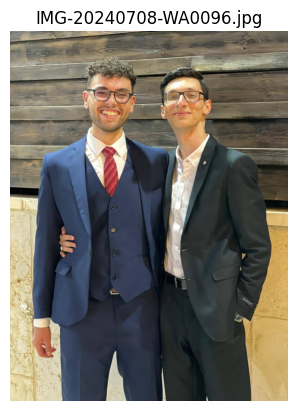


--- Processing Original Image: IMG-20240708-WA0096.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmpfrcjtkr8
Detected 2 face(s) in IMG-20240708-WA0096.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmpfrcjtkr8\face_1_57b1e07c-601f-42a0-b09d-be6c9e4e435a.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmpfrcjtkr8\face_2_3c3d1d10-1107-4e0c-8cfa-d1fb8d1a6c4a.jpg (Confidence: 1.00)

Checking status for 2 extracted face(s)...

-> Checking extracted face 1/2 (face_1_57b1e07c-601f-42a0-b09d-be6c9e4e435a.jpg):
Top match found: Identity 'rasheed' from path 'DB\rasheed\Screenshot 2025-04-17 001202.png'
Check result for face_1_57b1e07c-601f-42a0-b09d-be6c9e4e435a.jpg: Status='BANNED', Matched ID='rasheed', Passed=False, Banned=True
Result for face 1: Status='BANNED', Matched ID='rasheed'

-> Checking extracted face 2/2 (face_2_3c3d1d10-1107-4e0c-8cfa-d1fb8d1a6c4a.jpg):
No matching face found in the database for C:\Users\pc\AppD

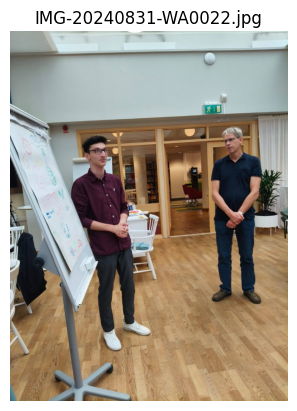


--- Processing Original Image: IMG-20240831-WA0022.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmpcp6289sn
Detected 2 face(s) in IMG-20240831-WA0022.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmpcp6289sn\face_1_509cdf87-5c8b-495b-ab37-fa50e6b572b9.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmpcp6289sn\face_2_97aaa7f2-a035-41fe-b7dd-0b39799c2a90.jpg (Confidence: 1.00)

Checking status for 2 extracted face(s)...

-> Checking extracted face 1/2 (face_1_509cdf87-5c8b-495b-ab37-fa50e6b572b9.jpg):
No matching face found in the database for C:\Users\pc\AppData\Local\Temp\tmpcp6289sn\face_1_509cdf87-5c8b-495b-ab37-fa50e6b572b9.jpg
Check result for face_1_509cdf87-5c8b-495b-ab37-fa50e6b572b9.jpg: Status='NO_MATCH', Matched ID='None', Passed=False, Banned=False
Result for face 1: Status='NO_MATCH', Matched ID='None'

-> Checking extracted face 2/2 (face_2_97aaa7f2-a035-41fe-b7dd-0b39799c2a90.jpg):
Top match found: I

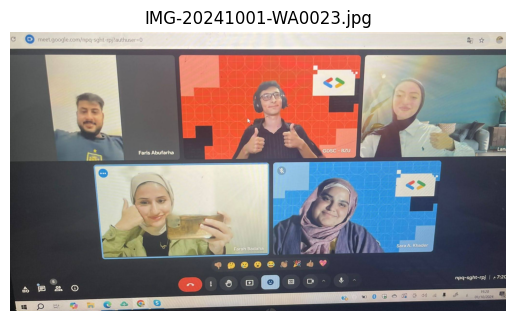


--- Processing Original Image: IMG-20241001-WA0023.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmptb2cblg1
Detected 5 face(s) in IMG-20241001-WA0023.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmptb2cblg1\face_1_9afc9b22-9e43-4465-9fb6-74da18751457.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmptb2cblg1\face_2_177a7f19-0473-445d-870f-3a5d13e6ca87.jpg (Confidence: 1.00)
  Saved detected face 3 to C:\Users\pc\AppData\Local\Temp\tmptb2cblg1\face_3_b825c5fa-62fd-44f4-90a6-98b334bd4cb3.jpg (Confidence: 1.00)
  Saved detected face 4 to C:\Users\pc\AppData\Local\Temp\tmptb2cblg1\face_4_85ad4e04-709e-4534-b8ff-dbd326685ec3.jpg (Confidence: 1.00)
  Saved detected face 5 to C:\Users\pc\AppData\Local\Temp\tmptb2cblg1\face_5_615adaae-2e89-462e-8b16-54ce60ffddff.jpg (Confidence: 1.00)

Checking status for 5 extracted face(s)...

-> Checking extracted face 1/5 (face_1_9afc9b22-9e43-4465-9fb6-74da18751457.jpg):
No matching

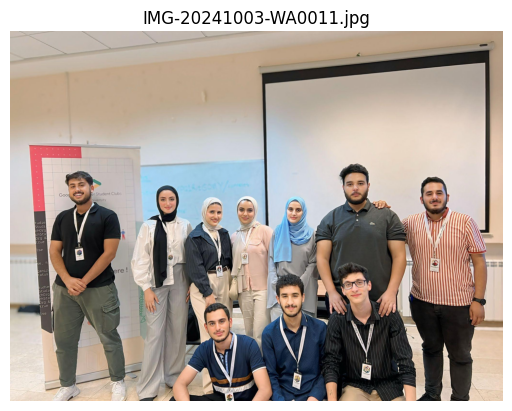


--- Processing Original Image: IMG-20241003-WA0011.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k
Detected 10 face(s) in IMG-20241003-WA0011.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k\face_1_c53502ae-9578-4eed-8cf6-7f610ef37816.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k\face_2_fc66e33d-561c-4899-95a6-3715a9d338b8.jpg (Confidence: 1.00)
  Saved detected face 3 to C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k\face_3_ef888caf-c838-4f73-abac-a961d5c5a8cc.jpg (Confidence: 1.00)
  Saved detected face 4 to C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k\face_4_6be66f92-e195-4060-ae9c-79543c7e09c6.jpg (Confidence: 1.00)
  Saved detected face 5 to C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k\face_5_151ad76f-9cd9-4b10-a780-5f8c9a05000d.jpg (Confidence: 1.00)
  Saved detected face 6 to C:\Users\pc\AppData\Local\Temp\tmpfjgsi42k\face_6_2dc3d549-3710-4403-9468-b257f427238c.jpg (Confidence: 0.99)


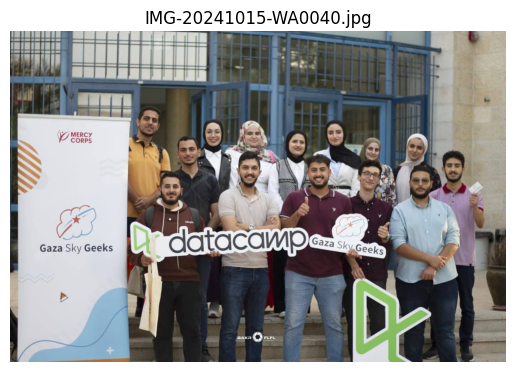


--- Processing Original Image: IMG-20241015-WA0040.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg
Detected 14 face(s) in IMG-20241015-WA0040.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg\face_1_a2516d8e-0084-4864-9bc8-851c4cac0def.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg\face_2_c0268cf0-6ebd-45d7-a1e8-252c1a6599b3.jpg (Confidence: 1.00)
  Saved detected face 3 to C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg\face_3_5ba3a5a4-2fd3-4ac9-bb7a-9f2f65b521f9.jpg (Confidence: 1.00)
  Saved detected face 4 to C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg\face_4_98e29366-3991-48f0-ae16-19d64f3b242f.jpg (Confidence: 1.00)
  Saved detected face 5 to C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg\face_5_e7822a89-2e18-4c1e-b2a0-444093864b01.jpg (Confidence: 1.00)
  Saved detected face 6 to C:\Users\pc\AppData\Local\Temp\tmpr8f38mcg\face_6_51e78765-d98d-49b9-9319-ead2e83b7f8f.jpg (Confidence: 1.00)


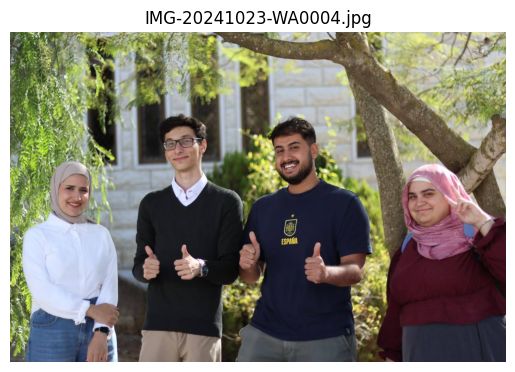


--- Processing Original Image: IMG-20241023-WA0004.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp_ruzw5dl
Detected 4 face(s) in IMG-20241023-WA0004.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp_ruzw5dl\face_1_a97cf81f-5b2b-467f-bf9a-225b721c817a.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmp_ruzw5dl\face_2_fddf08f0-35ff-4d33-b647-70aa79615b78.jpg (Confidence: 1.00)
  Saved detected face 3 to C:\Users\pc\AppData\Local\Temp\tmp_ruzw5dl\face_3_1422483e-52b5-4b3e-97e5-7811ba4b0e66.jpg (Confidence: 1.00)
  Saved detected face 4 to C:\Users\pc\AppData\Local\Temp\tmp_ruzw5dl\face_4_62e88994-e884-4275-8b36-59f5b6a02824.jpg (Confidence: 1.00)

Checking status for 4 extracted face(s)...

-> Checking extracted face 1/4 (face_1_a97cf81f-5b2b-467f-bf9a-225b721c817a.jpg):
Top match found: Identity 'faris' from path 'DB\faris\Screenshot 2025-04-17 000753.png'
Check result for face_1_a97cf81f-5b2b-467f-bf9a-225b721c817a

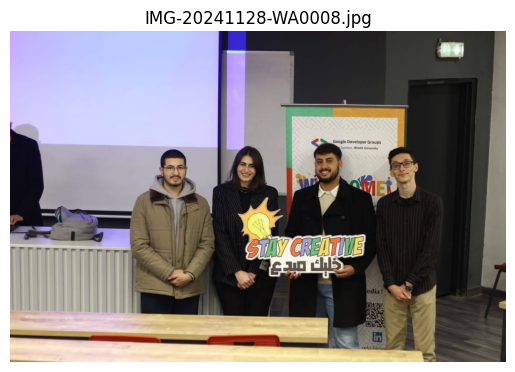


--- Processing Original Image: IMG-20241128-WA0008.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp7qkcu1ci
Detected 4 face(s) in IMG-20241128-WA0008.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp7qkcu1ci\face_1_6f48a09c-c617-4e2b-8924-d6b15413a731.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmp7qkcu1ci\face_2_0e1f03f3-8b54-419e-b3eb-12cb2613e392.jpg (Confidence: 1.00)
  Saved detected face 3 to C:\Users\pc\AppData\Local\Temp\tmp7qkcu1ci\face_3_0e354892-e87e-4c52-a92b-9d22c9d5ff44.jpg (Confidence: 1.00)
  Saved detected face 4 to C:\Users\pc\AppData\Local\Temp\tmp7qkcu1ci\face_4_1a2b9817-8f7b-4542-85ff-addb831ca820.jpg (Confidence: 1.00)

Checking status for 4 extracted face(s)...

-> Checking extracted face 1/4 (face_1_6f48a09c-c617-4e2b-8924-d6b15413a731.jpg):
No matching face found in the database for C:\Users\pc\AppData\Local\Temp\tmp7qkcu1ci\face_1_6f48a09c-c617-4e2b-8924-d6b15413a731.jpg
Check result f

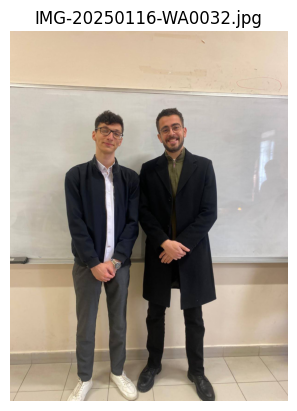


--- Processing Original Image: IMG-20250116-WA0032.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmps3bwmj0s
Detected 2 face(s) in IMG-20250116-WA0032.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmps3bwmj0s\face_1_1d2489b6-9d98-4f69-8ea9-6d9d616ced35.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmps3bwmj0s\face_2_7096e34f-c8b7-4cd3-af68-9a6492ca457a.jpg (Confidence: 1.00)

Checking status for 2 extracted face(s)...

-> Checking extracted face 1/2 (face_1_1d2489b6-9d98-4f69-8ea9-6d9d616ced35.jpg):
Top match found: Identity 'rasheed' from path 'DB\rasheed\Screenshot 2025-04-17 001240.png'
Check result for face_1_1d2489b6-9d98-4f69-8ea9-6d9d616ced35.jpg: Status='BANNED', Matched ID='rasheed', Passed=False, Banned=True
Result for face 1: Status='BANNED', Matched ID='rasheed'

-> Checking extracted face 2/2 (face_2_7096e34f-c8b7-4cd3-af68-9a6492ca457a.jpg):
No matching face found in the database for C:\Users\pc\AppD

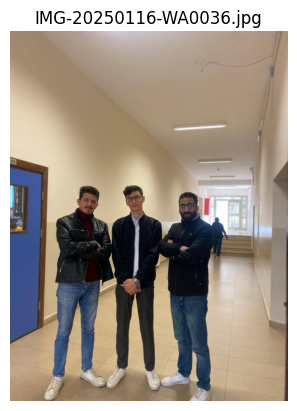


--- Processing Original Image: IMG-20250116-WA0036.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp0y9acx79
Detected 3 face(s) in IMG-20250116-WA0036.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp0y9acx79\face_1_db12f999-2706-4954-8592-fbe02955347d.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmp0y9acx79\face_2_37ee3fe6-e789-44bd-a821-4d3e527234e7.jpg (Confidence: 1.00)
  Saved detected face 3 to C:\Users\pc\AppData\Local\Temp\tmp0y9acx79\face_3_cbb6a533-7a6d-4cd4-9a72-0a46f2e328a1.jpg (Confidence: 1.00)

Checking status for 3 extracted face(s)...

-> Checking extracted face 1/3 (face_1_db12f999-2706-4954-8592-fbe02955347d.jpg):
No matching face found in the database for C:\Users\pc\AppData\Local\Temp\tmp0y9acx79\face_1_db12f999-2706-4954-8592-fbe02955347d.jpg
Check result for face_1_db12f999-2706-4954-8592-fbe02955347d.jpg: Status='NO_MATCH', Matched ID='None', Passed=False, Banned=False
Result for face 1: S

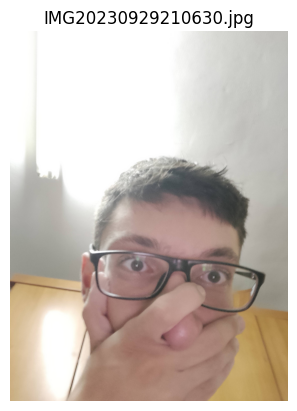


--- Processing Original Image: IMG20230929210630.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp3wcj3lg_
Detected 1 face(s) in IMG20230929210630.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp3wcj3lg_\face_1_2246b478-70df-408c-aaab-a83a78cd78cf.jpg (Confidence: 1.00)

Checking status for 1 extracted face(s)...

-> Checking extracted face 1/1 (face_1_2246b478-70df-408c-aaab-a83a78cd78cf.jpg):
An error occurred during face recognition for C:\Users\pc\AppData\Local\Temp\tmp3wcj3lg_\face_1_2246b478-70df-408c-aaab-a83a78cd78cf.jpg: Face could not be detected in C:\Users\pc\AppData\Local\Temp\tmp3wcj3lg_\face_1_2246b478-70df-408c-aaab-a83a78cd78cf.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Check result for face_1_2246b478-70df-408c-aaab-a83a78cd78cf.jpg: Status='ERROR', Matched ID='None', Passed=False, Banned=False
Result for face 1: Status='ERROR', Matched ID='None'

Cleaning up temporary

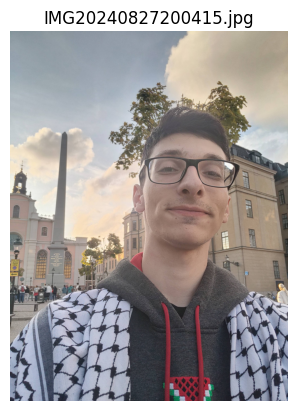


--- Processing Original Image: IMG20240827200415.jpg ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp35hek5o7
Detected 1 face(s) in IMG20240827200415.jpg.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp35hek5o7\face_1_ad8aad5e-f65f-4ef6-9701-0e4377896310.jpg (Confidence: 1.00)

Checking status for 1 extracted face(s)...

-> Checking extracted face 1/1 (face_1_ad8aad5e-f65f-4ef6-9701-0e4377896310.jpg):
Top match found: Identity 'rasheed' from path 'DB\rasheed\Screenshot 2025-04-17 001240.png'
Check result for face_1_ad8aad5e-f65f-4ef6-9701-0e4377896310.jpg: Status='BANNED', Matched ID='rasheed', Passed=False, Banned=True
Result for face 1: Status='BANNED', Matched ID='rasheed'

Cleaning up temporary directory: C:\Users\pc\AppData\Local\Temp\tmp35hek5o7
--- Finished Processing IMG20240827200415.jpg ---
Result: Status='BANNED', Matched ID='rasheed'

--- Processing Image: IMG_3091.JPG ---


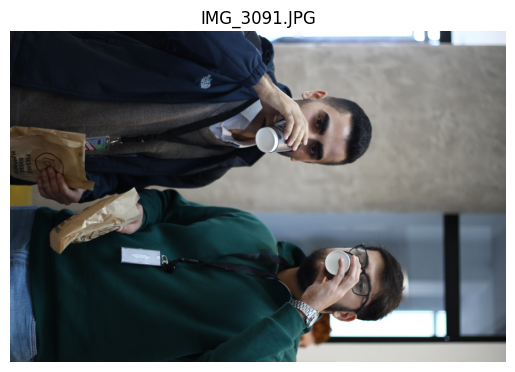


--- Processing Original Image: IMG_3091.JPG ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmplgmxa0jw
Detected 2 face(s) in IMG_3091.JPG.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmplgmxa0jw\face_1_1062a3dd-1c18-448d-8592-e275d5811ea1.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmplgmxa0jw\face_2_c0ac538d-2803-4d3e-be4c-97bd86fadd94.jpg (Confidence: 1.00)

Checking status for 2 extracted face(s)...

-> Checking extracted face 1/2 (face_1_1062a3dd-1c18-448d-8592-e275d5811ea1.jpg):
No matching face found in the database for C:\Users\pc\AppData\Local\Temp\tmplgmxa0jw\face_1_1062a3dd-1c18-448d-8592-e275d5811ea1.jpg
Check result for face_1_1062a3dd-1c18-448d-8592-e275d5811ea1.jpg: Status='NO_MATCH', Matched ID='None', Passed=False, Banned=False
Result for face 1: Status='NO_MATCH', Matched ID='None'

-> Checking extracted face 2/2 (face_2_c0ac538d-2803-4d3e-be4c-97bd86fadd94.jpg):
An error occurred during face recognitio

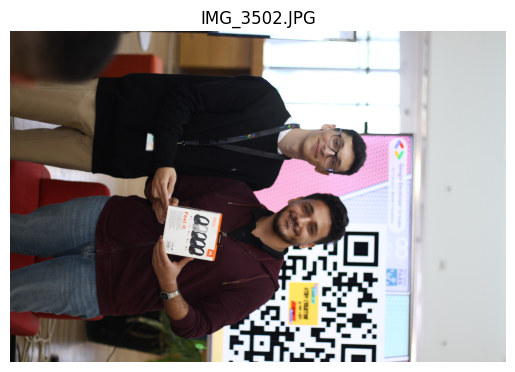


--- Processing Original Image: IMG_3502.JPG ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp5dbgz1pq
Detected 2 face(s) in IMG_3502.JPG.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp5dbgz1pq\face_1_e052baa7-53ca-41fb-affa-697eb141be8b.jpg (Confidence: 1.00)
  Saved detected face 2 to C:\Users\pc\AppData\Local\Temp\tmp5dbgz1pq\face_2_f4e0434e-deeb-46e3-9c53-d25f7fdecc59.jpg (Confidence: 1.00)

Checking status for 2 extracted face(s)...

-> Checking extracted face 1/2 (face_1_e052baa7-53ca-41fb-affa-697eb141be8b.jpg):
No matching face found in the database for C:\Users\pc\AppData\Local\Temp\tmp5dbgz1pq\face_1_e052baa7-53ca-41fb-affa-697eb141be8b.jpg
Check result for face_1_e052baa7-53ca-41fb-affa-697eb141be8b.jpg: Status='NO_MATCH', Matched ID='None', Passed=False, Banned=False
Result for face 1: Status='NO_MATCH', Matched ID='None'

-> Checking extracted face 2/2 (face_2_f4e0434e-deeb-46e3-9c53-d25f7fdecc59.jpg):
Top match found: Identity 'rasheed' from

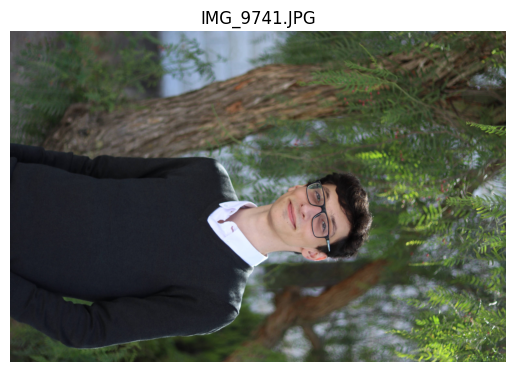


--- Processing Original Image: IMG_9741.JPG ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmpb3sqmqbh
Detected 1 face(s) in IMG_9741.JPG.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmpb3sqmqbh\face_1_207d7ea3-8838-4126-bcb1-cccf77c90cdf.jpg (Confidence: 1.00)

Checking status for 1 extracted face(s)...

-> Checking extracted face 1/1 (face_1_207d7ea3-8838-4126-bcb1-cccf77c90cdf.jpg):
Top match found: Identity 'rasheed' from path 'DB\rasheed\Screenshot 2025-04-17 001240.png'
Check result for face_1_207d7ea3-8838-4126-bcb1-cccf77c90cdf.jpg: Status='BANNED', Matched ID='rasheed', Passed=False, Banned=True
Result for face 1: Status='BANNED', Matched ID='rasheed'

Cleaning up temporary directory: C:\Users\pc\AppData\Local\Temp\tmpb3sqmqbh
--- Finished Processing IMG_9741.JPG ---
Result: Status='BANNED', Matched ID='rasheed'

--- Processing Image: IMG_9881.JPG ---


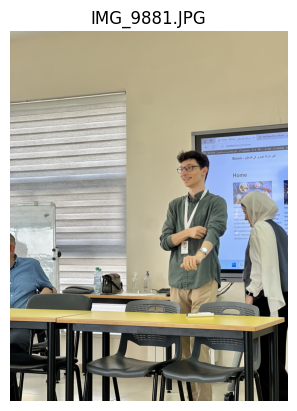


--- Processing Original Image: IMG_9881.JPG ---
Using temporary directory: C:\Users\pc\AppData\Local\Temp\tmp5zbbi90j
Detected 1 face(s) in IMG_9881.JPG.
  Saved detected face 1 to C:\Users\pc\AppData\Local\Temp\tmp5zbbi90j\face_1_4e8de870-e173-47f3-9984-1c4a8ca72a9e.jpg (Confidence: 0.99)

Checking status for 1 extracted face(s)...

-> Checking extracted face 1/1 (face_1_4e8de870-e173-47f3-9984-1c4a8ca72a9e.jpg):
No matching face found in the database for C:\Users\pc\AppData\Local\Temp\tmp5zbbi90j\face_1_4e8de870-e173-47f3-9984-1c4a8ca72a9e.jpg
Check result for face_1_4e8de870-e173-47f3-9984-1c4a8ca72a9e.jpg: Status='NO_MATCH', Matched ID='None', Passed=False, Banned=False
Result for face 1: Status='NO_MATCH', Matched ID='None'

Cleaning up temporary directory: C:\Users\pc\AppData\Local\Temp\tmp5zbbi90j
--- Finished Processing IMG_9881.JPG ---
Result: Status='NO_MATCH', Matched ID='None'


In [18]:
# Define the directory containing test images
TEST_IMAGES_DIRECTORY = "C:\\Users\\pc\\Downloads\\Photos-001"

# Call the function to process all images in the directory
process_images_in_directory(TEST_IMAGES_DIRECTORY, DATABASE_PATH, PASSED_USERS, BANNED_USERS, enforce_detection=True)